In [ ]:
import warnings
from sklearn.metrics import mean_absolute_error
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
import seaborn as sns
sns.set(style="white") #white background style for seaborn plots
sns.set(style="whitegrid", color_codes=True)
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate
from keras.layers import Bidirectional
import re
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error
from math import sqrt

**Acquérir les données et créer le Dataframe**

**A) Scrapping :**

Identification des critères de recherches afin d'avoir plus d'informations. Collecter les données nécessaires permettant de prédire le prix futur et la production fututre des tomates.

**B) Description des données:**

Au total, il y a 425 observations et 11 variables qualitatives. Les données sont:

la date le prix moyen au kg le prix minimal le prix maximal la température minimale en °C la température maximale en °C le taux de précipitations en mm l'ensoleillement en min la vitesse du vent en km/h la catégorie de la tomate

**Modèle**

In [ ]:
Pop = pd.read_csv("/content/TM.csv")
Pop=Pop.iloc[pd.to_datetime(Pop.Date.astype(str)).argsort()] #pour mettre les dates dans l'ordre
Pop

,Date,prix moyen au kg,Production quantité \ntonne(s),Température minimale en °C,Température maximale en °C,précipitations en mm,Ensoleillement en min,Rafales (vitesse du vent) en km/h
354,01/08/12,1.30,0.20,11.8,28.0,0.4,445,44.4
333,01/10/12,1.10,0.20,3.5,19.1,0.8,536,40.7
332,02/10/12,1.10,0.20,12.8,18.8,0.2,121,38.9
353,03/08/12,1.25,0.30,12.0,24.1,0.4,330,42.8
342,04/09/12,1.10,0.40,12.8,25.7,0.0,672,37.0
...,...,...,...,...,...,...,...,...
388,11/09/20,1.75,0.50,14.1,28.2,0.0,552,29.5
19,11/09/20,1.05,0.50,14.1,28.2,0.0,552,29.5
373,19/11/20,1.80,0.05,5.8,11.5,0.0,352,61.2
372,20/11/20,1.50,0.10,-0.1,10.6,0.0,297,26.3


In [ ]:
Pop['Date'] = pd.to_datetime(Pop['Date'],infer_datetime_format=True) 
Pop = Pop.set_index(['Date'])
Pop

,prix moyen au kg,Production quantité \ntonne(s),Température minimale en °C,Température maximale en °C,précipitations en mm,Ensoleillement en min,Rafales (vitesse du vent) en km/h
Date,,,,,,,
2012-01-08,1.30,0.20,11.8,28.0,0.4,445,44.4
2012-01-10,1.10,0.20,3.5,19.1,0.8,536,40.7
2012-02-10,1.10,0.20,12.8,18.8,0.2,121,38.9
2012-03-08,1.25,0.30,12.0,24.1,0.4,330,42.8
2012-04-09,1.10,0.40,12.8,25.7,0.0,672,37.0
...,...,...,...,...,...,...,...
2020-11-09,1.75,0.50,14.1,28.2,0.0,552,29.5
2020-11-09,1.05,0.50,14.1,28.2,0.0,552,29.5
2020-11-19,1.80,0.05,5.8,11.5,0.0,352,61.2


**Pour le prix**

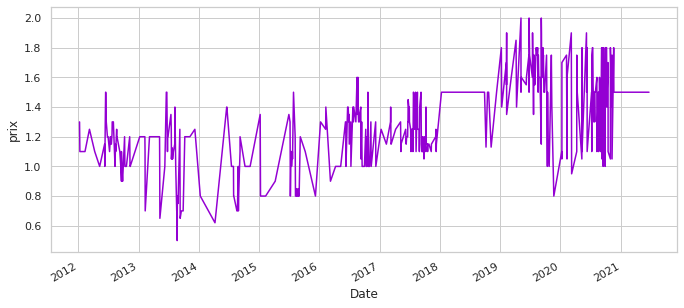

In [ ]:
Prix = Pop['prix moyen au kg']
Prix.plot(figsize=(10,5), color = 'darkviolet')
plt.ylabel('prix')
plt.show()

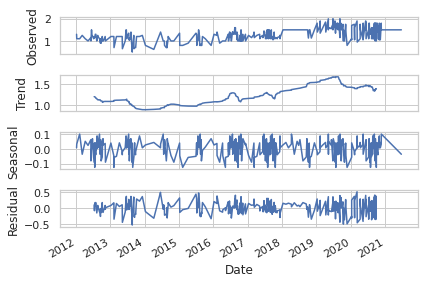

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(Prix, freq=30)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

decomposition.plot()
plt.show()

Text(0.5, 0, 'Année')

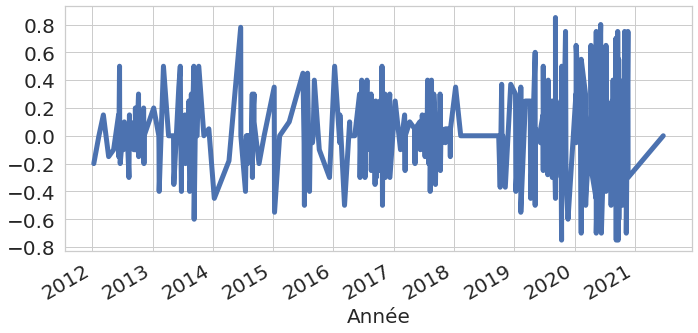

In [ ]:
Prix.diff().plot(figsize=(10,5), linewidth=5, fontsize=20)
plt.xlabel('Année', fontsize=20)

In [ ]:
from statsmodels.tsa.stattools import adfuller
def check_stationarity(timeseries):
    result = adfuller(timeseries,autolag='AIC')
    dfoutput = pd.Series(result[0:4], index=['Test Statistic','p-value','#Lags Used','Nb observations'])
    print('The test statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('%s: %.3f' % (key, value))


In [ ]:
check_stationarity(Prix)

The test statistic: -2.466145
p-value: 0.123930
Critical Values:
1%: -3.446
5%: -2.869
10%: -2.570


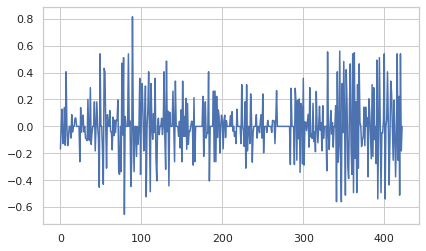

In [ ]:
ts_temp_log = np.log(Prix)
ts_temp_log_diff = np.diff(ts_temp_log)
plt.plot(ts_temp_log_diff)

In [ ]:
check_stationarity(ts_temp_log_diff)

The test statistic: -6.821642
p-value: 0.000000
Critical Values:
1%: -3.447
5%: -2.869
10%: -2.571


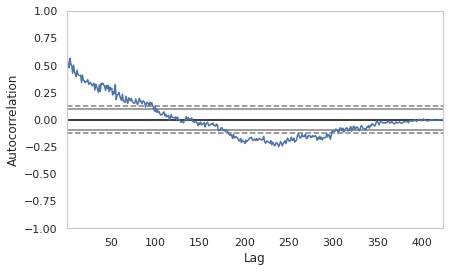

In [ ]:
pd.plotting.autocorrelation_plot(Prix)

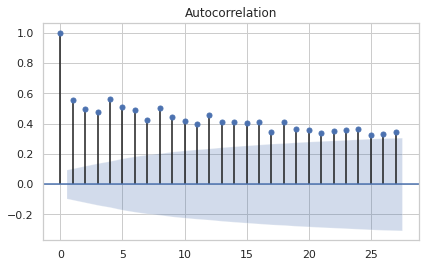

In [ ]:
plot_acf(Prix)
plt.show()

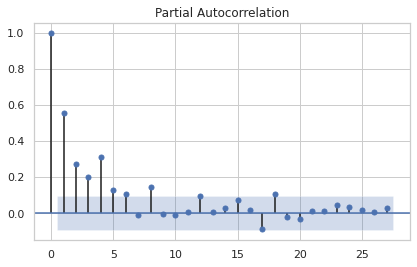

In [ ]:
plot_pacf(Prix)
plt.show()

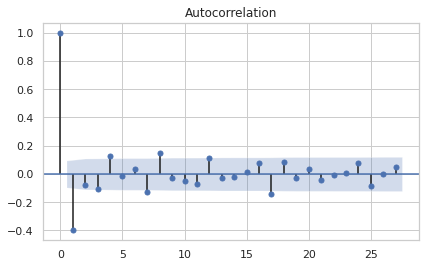

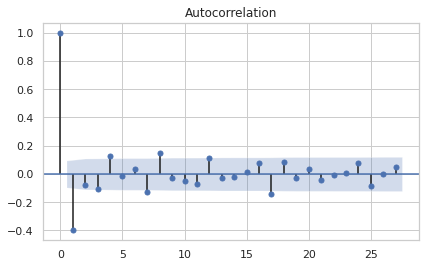

In [ ]:
plot_acf(ts_temp_log_diff)

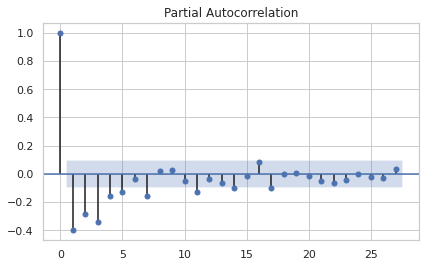

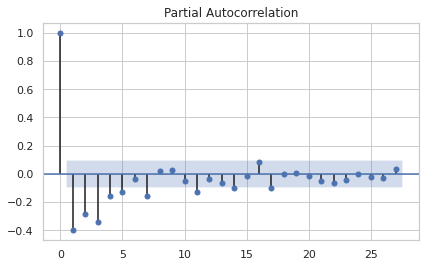

In [ ]:
plot_pacf(ts_temp_log_diff)

In [ ]:
mod = ARIMA(Prix,order=(1,0,3))
results = mod.fit()
print(results.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



                              ARMA Model Results                              
Dep. Variable:       prix moyen au kg   No. Observations:                  424
Model:                     ARMA(1, 3)   Log Likelihood                  53.198
Method:                       css-mle   S.D. of innovations              0.213
Date:                Wed, 29 Sep 2021   AIC                            -94.396
Time:                        07:39:45   BIC                            -70.098
Sample:                             0   HQIC                           -84.796
                                                                              
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      1.2766      0.092     13.887      0.000       1.096       1.457
ar.L1.prix moyen au kg     0.9794      0.012     81.947      0.000       0.956       1.003
ma.L

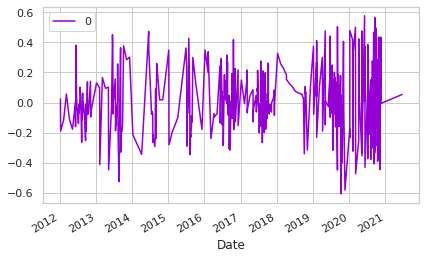

In [ ]:
residuals = pd.DataFrame(results.resid)
residuals.plot(color = 'darkviolet')

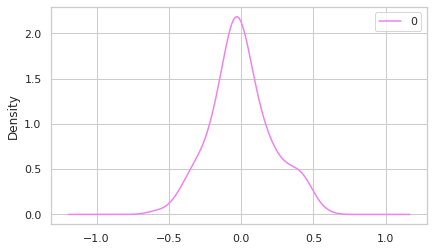

In [ ]:
residuals.plot(kind='kde', color = 'violet')

In [ ]:
residuals.describe()

,0
count,424.000000
mean,0.001462
std,0.213462
min,-0.605705
25%,-0.124448
50%,-0.012752
75%,0.121039
max,0.576353


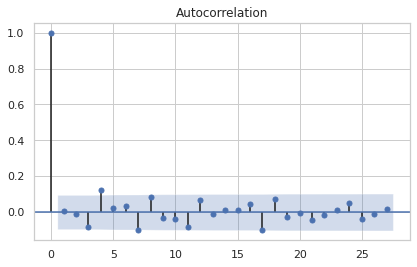

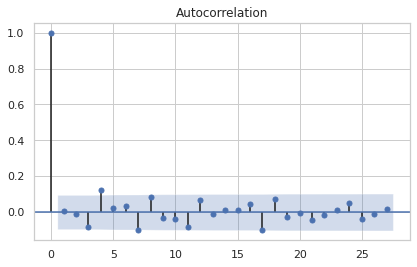

In [ ]:
plot_acf(residuals)

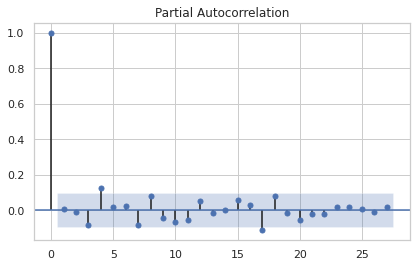

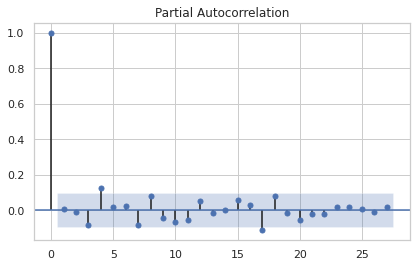

In [ ]:
plot_pacf(residuals)

In [ ]:
from math import sqrt
from sklearn.metrics import mean_squared_error, r2_score

R2P = r2_score(Prix, results.predict())
print(R2P)

rmseP =sqrt(mean_squared_error(Prix, results.predict()))
print(rmseP)

0.45155944432642814
0.2132153196940382


In [ ]:
mean_absolute_error(Prix, results.predict())

0.1637913914464851

**Prédiction du prix des tomates dans 7 jours**

In [ ]:
n=7
forecast,err,ci = results.forecast(steps= n, alpha = 0.05)
df_forecast = pd.DataFrame({'Prix dans 7 jours':forecast},index=pd.date_range(start='2021-06-22', periods=n, freq='D'))
df_forecast

,Prix dans 7 jours
2021-06-22,1.474224
2021-06-23,1.465785
2021-06-24,1.464320
2021-06-25,1.460457
2021-06-26,1.456674
2021-06-27,1.452968
2021-06-28,1.449339


D'après ce dataframe, on en déduit que le prix dans 7 jours aura tendance à diminuer. Cependant, par rapport à au 21/06/2021, le prix a tendance à diminuer

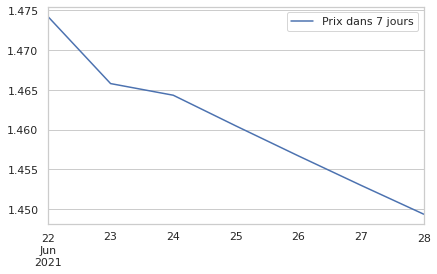

In [ ]:
df_forecast.plot()

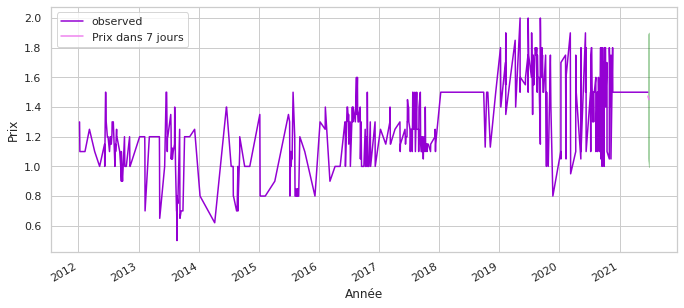

In [ ]:
ax = Prix.plot(label='observed', figsize=(10,5), color = 'darkviolet')
df_forecast.plot(ax=ax,label='Forecast',color='violet')
ax.fill_between(df_forecast.index,
                ci[:,0],
                ci[:,1], color='green', alpha=.25)
ax.set_xlabel('Année')
ax.set_ylabel('Prix')

plt.legend()
plt.show()

**Pour la production**

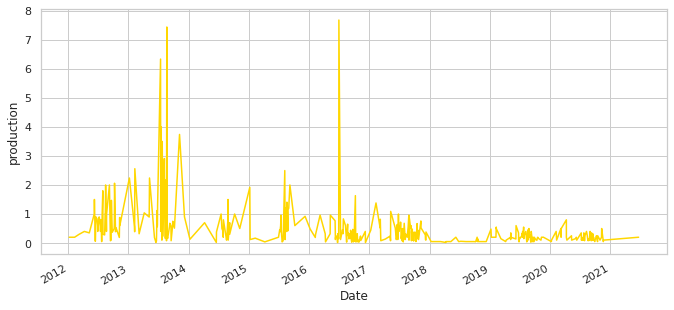

In [ ]:
Production = Pop['Production quantité \ntonne(s)']
Production.plot(figsize=(10,5), color = 'gold')
plt.ylabel('production')
plt.show()

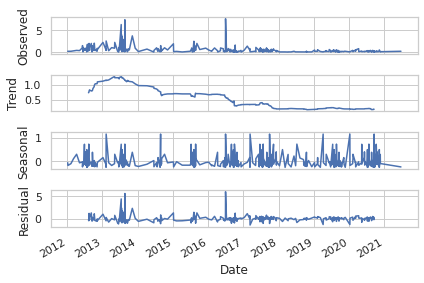

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(Production, freq=50)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

decomposition.plot()
plt.show()

In [ ]:
check_stationarity(Production)

The test statistic: -2.221031
p-value: 0.198701
Critical Values:
1%: -3.446
5%: -2.869
10%: -2.571


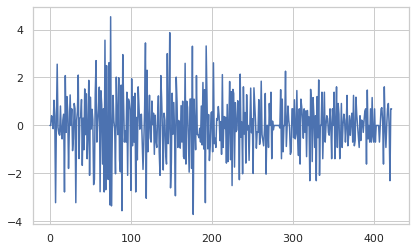

In [ ]:
ts_temp_log2 = np.log(Production)
ts_temp_log_diff2 = np.diff(ts_temp_log2)
plt.plot(ts_temp_log_diff2)


Text(0.5, 0, 'Année')

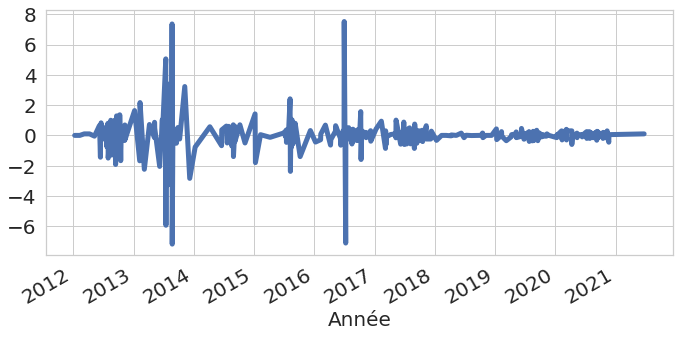

In [ ]:
Production.diff().plot(figsize=(10,5), linewidth=5, fontsize=20)
plt.xlabel('Année', fontsize=20)

In [ ]:
check_stationarity(ts_temp_log_diff2)

The test statistic: -9.456268
p-value: 0.000000
Critical Values:
1%: -3.446
5%: -2.869
10%: -2.571


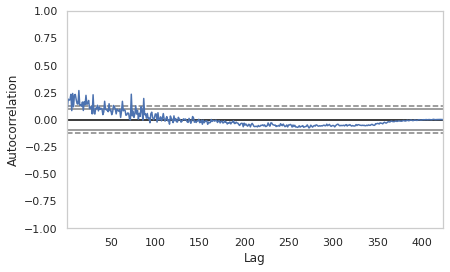

In [ ]:
pd.plotting.autocorrelation_plot(Production)

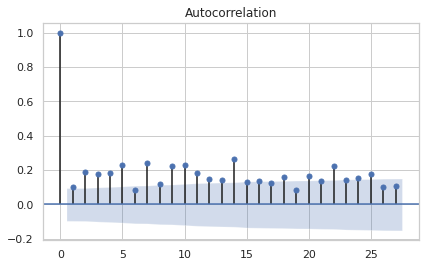

In [ ]:
plot_acf(Production)
plt.show()

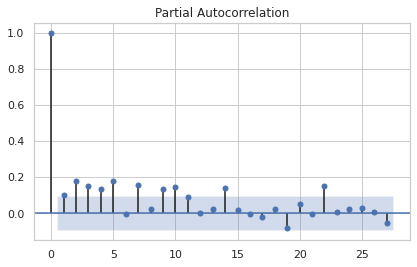

In [ ]:
plot_pacf(Production)
plt.show()

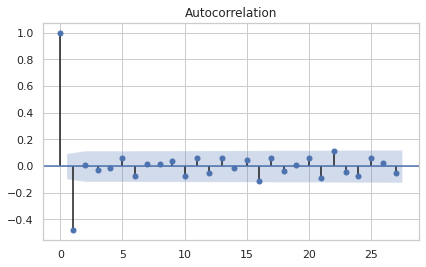

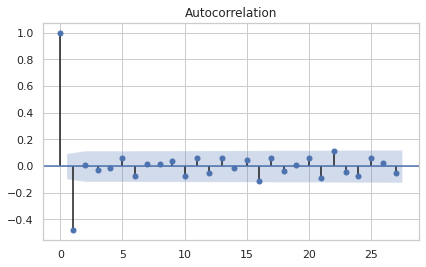

In [ ]:
plot_acf(ts_temp_log_diff2)

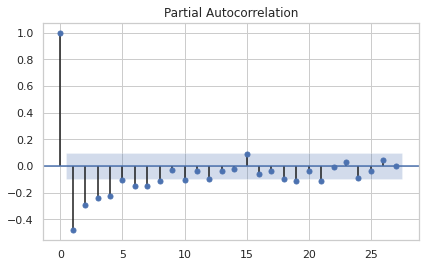

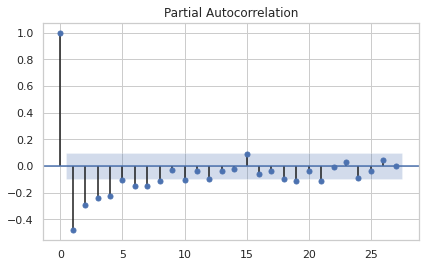

In [ ]:
plot_pacf(ts_temp_log_diff2)

In [ ]:
mod2 = ARIMA(Production,order=(1,0,3))
results2 = mod2.fit()
print(results2.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



                                    ARMA Model Results                                   
Dep. Variable:     Production quantité 
tonne(s)   No. Observations:                  424
Model:                                ARMA(1, 3)   Log Likelihood                -461.585
Method:                                  css-mle   S.D. of innovations              0.718
Date:                           Wed, 29 Sep 2021   AIC                            935.170
Time:                                   07:44:54   BIC                            959.469
Sample:                                        0   HQIC                           944.770
                                                                                         
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                   0.4427      0.165      2.686    

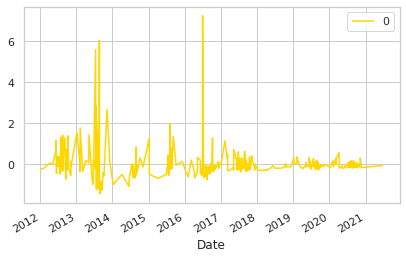

In [ ]:
residuals2 = pd.DataFrame(results2.resid)
residuals2.plot(color = 'gold')

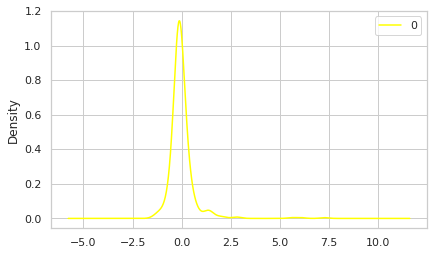

In [ ]:
residuals2.plot(kind='kde', color = 'yellow')

In [ ]:
residuals2.describe()

,0
count,424.000000
mean,-0.000939
std,0.719070
min,-1.435242
25%,-0.246023
50%,-0.118912
75%,0.077707
max,7.253112


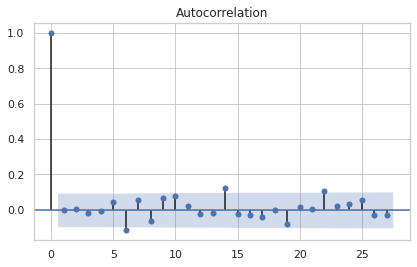

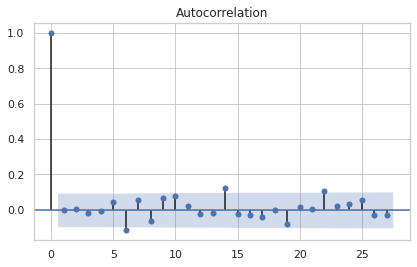

In [ ]:
plot_acf(residuals2)

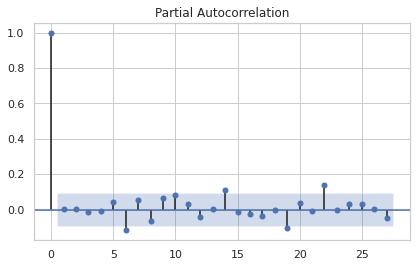

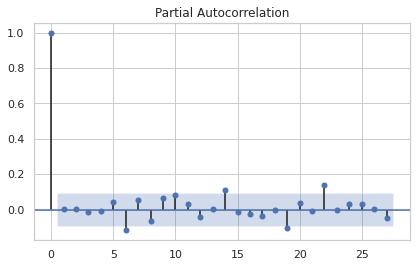

In [ ]:
plot_pacf(residuals2)

In [ ]:
from math import sqrt
from sklearn.metrics import mean_squared_error, r2_score

R2Po = r2_score(Production, results2.predict())
print(R2Po)

rmsePo =sqrt(mean_squared_error(Production, results2.predict()))
print(rmsePo)

0.1430754800447196
0.7182218814026265


In [ ]:
mean_absolute_error(Production, results2.predict())

0.3548870748089981

**Prédiction de la production des tomates dans 7 jours**

In [ ]:
n=7
forecast,err,ci = results2.forecast(steps= n, alpha = 0.05)
df_forecast2 = pd.DataFrame({'Production dans 7 jours':forecast},index=pd.date_range(start='2021-06-22', periods=n, freq='D'))
df_forecast2

,Production dans 7 jours
2021-06-22,0.242817
2021-06-23,0.238521
2021-06-24,0.241106
2021-06-25,0.244372
2021-06-26,0.247585
2021-06-27,0.250746
2021-06-28,0.253855


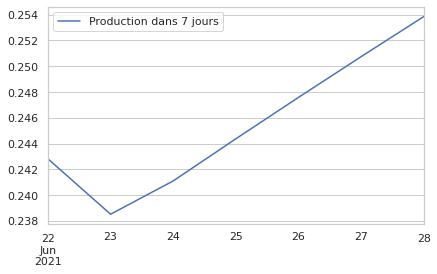

In [ ]:
df_forecast2.plot()

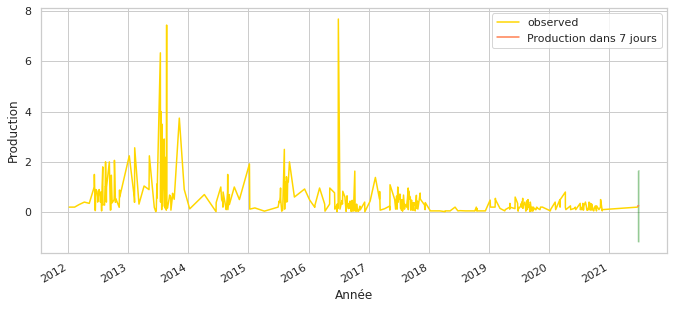

In [ ]:
ax = Production.plot(label='observed', figsize=(10,5), color = 'gold')
df_forecast2.plot(ax=ax,label='Forecast',color='coral')
ax.fill_between(df_forecast2.index,
                ci[:,0],
                ci[:,1], color='green', alpha=.25)
ax.set_xlabel('Année')
ax.set_ylabel('Production')

plt.legend()
plt.show()

**Prédiction de la météo**

In [ ]:
Tm = Pop["Température minimale en °C"]
TM = Pop["Température maximale en °C"]
P = Pop["précipitations en mm"]
E = Pop["Ensoleillement en min"]
V = Pop["Rafales (vitesse du vent) en km/h"]

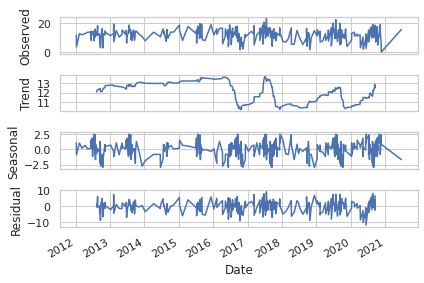

In [ ]:
#la température minimale

decomposition = seasonal_decompose(Tm, freq=50)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

decomposition.plot()
plt.show()

In [ ]:
check_stationarity(Tm)

The test statistic: -5.114091
p-value: 0.000013
Critical Values:
1%: -3.446
5%: -2.868
10%: -2.570


In [ ]:
ts_temp_log = np.log(Tm)
ts_temp_log

Date
2012-01-08    2.468100
2012-01-10    1.252763
2012-02-10    2.549445
2012-03-08    2.484907
2012-04-09    2.549445
                ...   
2020-11-09    2.646175
2020-11-09    2.646175
2020-11-19    1.757858
2020-11-20         NaN
2021-06-21    2.753661
Name: Température minimale en °C, Length: 424, dtype: float64

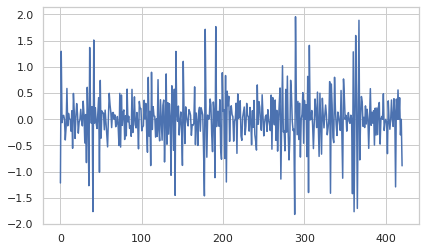

In [ ]:
ts_temp_log_diff = np.diff(ts_temp_log)

plt.plot(ts_temp_log_diff)

In [ ]:
mod = ARIMA(Tm,order=(0,0,3))
results3 = mod.fit()
print(results3.summary())

                                  ARMA Model Results                                  
Dep. Variable:     Température minimale en °C   No. Observations:                  424
Model:                             ARMA(0, 3)   Log Likelihood               -1168.058
Method:                               css-mle   S.D. of innovations              3.803
Date:                        Wed, 29 Sep 2021   AIC                           2346.116
Time:                                07:48:42   BIC                           2366.365
Sample:                                     0   HQIC                          2354.116
                                                                                      
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                               12.0496      0.263     45.829      0.000      11.534      12.565
m

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



In [ ]:
n=7
forecast,err,ci = results3.forecast(steps=n, alpha = 0.05)
df_forecast3 = pd.DataFrame({'température minimale dans 7 jours':forecast},index=pd.date_range(start='2021-06-22', periods=n, freq='D'))
df_forecast3

,température minimale dans 7 jours
2021-06-22,11.791237
2021-06-23,11.740337
2021-06-24,12.680943
2021-06-25,12.049612
2021-06-26,12.049612
2021-06-27,12.049612
2021-06-28,12.049612


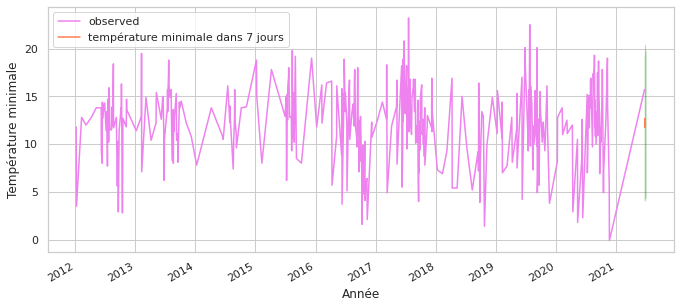

In [ ]:
ax = Tm.plot(label='observed', figsize=(10,5), color = 'violet')
df_forecast3.plot(ax=ax,label='Forecast',color='coral')
ax.fill_between(df_forecast3.index,
                ci[:,0],
                ci[:,1], color='green', alpha=.25)
ax.set_xlabel('Année')
ax.set_ylabel('Température minimale')

plt.legend()
plt.show()

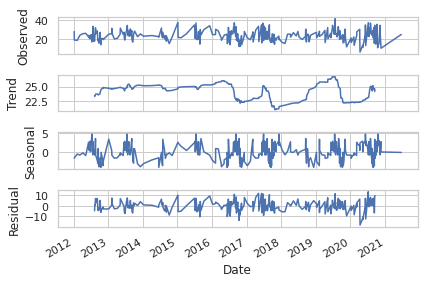

In [ ]:
#Température maximale



decomposition = seasonal_decompose(TM, freq=50)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

decomposition.plot()
plt.show()

In [ ]:
check_stationarity(TM)

The test statistic: -5.004658
p-value: 0.000022
Critical Values:
1%: -3.446
5%: -2.868
10%: -2.570


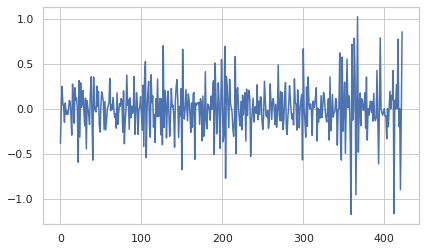

In [ ]:
ts_temp_log = np.log(TM)

ts_temp_log_diff = np.diff(ts_temp_log)

plt.plot(ts_temp_log_diff)

In [ ]:
mod = ARIMA(TM,order=(2,0,3))
results = mod.fit()
print(results.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



                                  ARMA Model Results                                  
Dep. Variable:     Température maximale en °C   No. Observations:                  424
Model:                             ARMA(2, 3)   Log Likelihood               -1284.048
Method:                               css-mle   S.D. of innovations              4.994
Date:                        Wed, 29 Sep 2021   AIC                           2582.096
Time:                                07:49:33   BIC                           2610.444
Sample:                                     0   HQIC                          2593.296
                                                                                      
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                               23.9680      0.290     82.643      0.000      23.400      24.536
a

In [ ]:
n=7
forecast,err,ci = results.forecast(steps=n, alpha = 0.05)
df_forecast4 = pd.DataFrame({'température maximale dans 7 jours':forecast},index=pd.date_range(start='2021-06-22', periods=n, freq='D'))
df_forecast4

,température maximale dans 7 jours
2021-06-22,23.484571
2021-06-23,21.822497
2021-06-24,22.034164
2021-06-25,22.252688
2021-06-26,22.476312
2021-06-27,22.703301
2021-06-28,22.931950


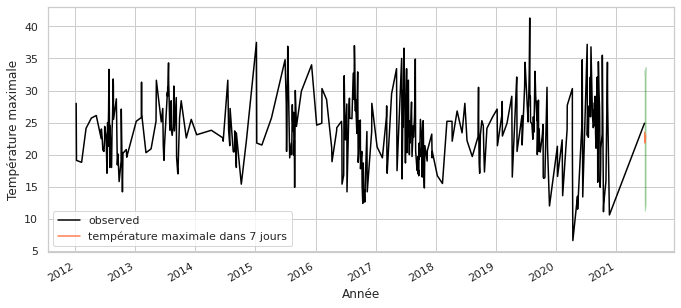

In [ ]:
ax = TM.plot(label='observed', figsize=(10,5), color = 'black')
df_forecast4.plot(ax=ax,label='Forecast',color='coral')
ax.fill_between(df_forecast4.index,
                ci[:,0],
                ci[:,1], color='green', alpha=.25)
ax.set_xlabel('Année')
ax.set_ylabel('Température maximale')

plt.legend()
plt.show()

In [ ]:
# les précipitations

mod = ARIMA(P,order=(0,0,3))
results = mod.fit()
print(results.summary())

                               ARMA Model Results                               
Dep. Variable:     précipitations en mm   No. Observations:                  424
Model:                       ARMA(0, 3)   Log Likelihood               -1223.130
Method:                         css-mle   S.D. of innovations              4.331
Date:                  Wed, 29 Sep 2021   AIC                           2456.259
Time:                          07:50:01   BIC                           2476.508
Sample:                               0   HQIC                          2464.259
                                                                                
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          1.4758      0.277      5.321      0.000       0.932       2.019
ma.L1.précipitations en mm     0.1531      0.049      3.112      0.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



In [ ]:
n=7
forecast,err,ci = results.forecast(steps=n, alpha = 0.05)
df_forecast5 = pd.DataFrame({'précipitations dans 7 jours':forecast},index=pd.date_range(start='2021-06-22', periods=n, freq='D'))
df_forecast5

,précipitations dans 7 jours
2021-06-22,1.699973
2021-06-23,1.786529
2021-06-24,1.572484
2021-06-25,1.475837
2021-06-26,1.475837
2021-06-27,1.475837
2021-06-28,1.475837


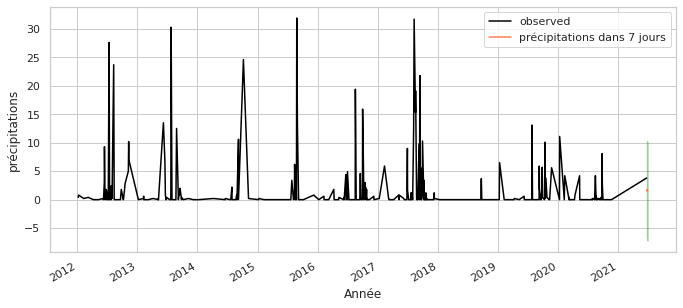

In [ ]:
ax = P.plot(label='observed', figsize=(10,5), color = 'black')
df_forecast5.plot(ax=ax,label='Forecast',color='coral')
ax.fill_between(df_forecast5.index,
                ci[:,0],
                ci[:,1], color='green', alpha=.25)
ax.set_xlabel('Année')
ax.set_ylabel('précipitations')

plt.legend()
plt.show()

In [ ]:
# l'ensoleillement

mod = ARIMA(E,order=(0,0,3))
results = mod.fit()
print(results.summary())

                                ARMA Model Results                               
Dep. Variable:     Ensoleillement en min   No. Observations:                  424
Model:                        ARMA(0, 3)   Log Likelihood               -2951.524
Method:                          css-mle   S.D. of innovations            255.214
Date:                   Wed, 29 Sep 2021   AIC                           5913.047
Time:                           07:50:31   BIC                           5933.296
Sample:                                0   HQIC                          5921.048
                                                                                 
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                         436.1604     17.729     24.602      0.000     401.413     470.908
ma.L1.Ensoleillement en min     0.2556      0.049      5

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



In [ ]:
n=7
forecast,err,ci = results.forecast(steps=n, alpha = 0.05)
df_forecast6 = pd.DataFrame({'Ensoleillement dans 7 jours':forecast},index=pd.date_range(start='2021-06-22', periods=n, freq='D'))
df_forecast6

,Ensoleillement dans 7 jours
2021-06-22,421.116357
2021-06-23,431.860813
2021-06-24,437.884841
2021-06-25,436.160377
2021-06-26,436.160377
2021-06-27,436.160377
2021-06-28,436.160377


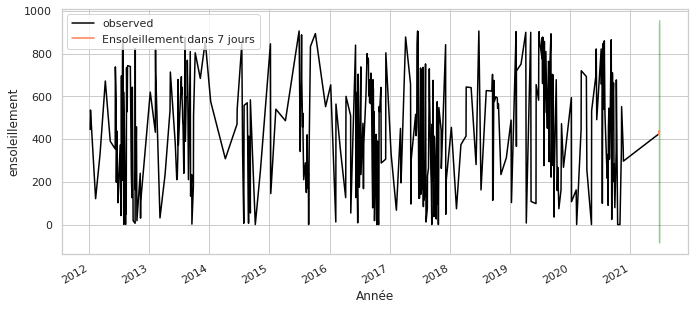

In [ ]:
ax = E.plot(label='observed', figsize=(10,5), color = 'black')
df_forecast6.plot(ax=ax,label='Forecast',color='coral')
ax.fill_between(df_forecast6.index,
                ci[:,0],
                ci[:,1], color='green', alpha=.25)
ax.set_xlabel('Année')
ax.set_ylabel('ensoleillement')

plt.legend()
plt.show()

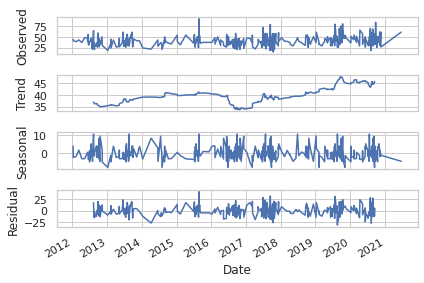

In [ ]:
decomposition = seasonal_decompose(V, freq=50)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

decomposition.plot()
plt.show()

In [ ]:
check_stationarity(V)

The test statistic: -8.853970
p-value: 0.000000
Critical Values:
1%: -3.446
5%: -2.868
10%: -2.570


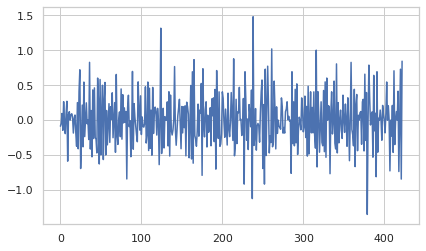

In [ ]:
ts_temp_log = np.log(V)

ts_temp_log_diff = np.diff(ts_temp_log)

plt.plot(ts_temp_log_diff)

In [ ]:
mod = ARIMA(V,order=(1,0,1))
results = mod.fit()
print(results.summary())

                                      ARMA Model Results                                     
Dep. Variable:     Rafales (vitesse du vent) en km/h   No. Observations:                  424
Model:                                    ARMA(1, 1)   Log Likelihood               -1655.128
Method:                                      css-mle   S.D. of innovations             11.995
Date:                               Wed, 29 Sep 2021   AIC                           3318.256
Time:                                       07:51:11   BIC                           3334.455
Sample:                                            0   HQIC                          3324.656
                                                                                             
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
const                           

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



In [ ]:
n=7
forecast,err,ci = results.forecast(steps=n, alpha = 0.05)
df_forecast7 = pd.DataFrame({'Vitesse du vent dans 7 jours':forecast},index=pd.date_range(start='2021-06-22', periods=n, freq='D'))
df_forecast7

,Vitesse du vent dans 7 jours
2021-06-22,42.985076
2021-06-23,42.462707
2021-06-24,42.035727
2021-06-25,41.686717
2021-06-26,41.401439
2021-06-27,41.168256
2021-06-28,40.977653


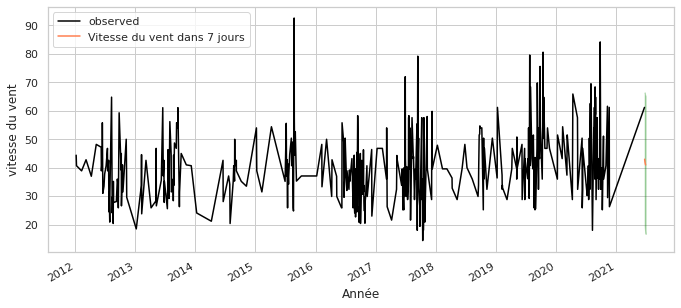

In [ ]:
ax = V.plot(label='observed', figsize=(10,5), color = 'black')
df_forecast7.plot(ax=ax,label='Forecast',color='coral')
ax.fill_between(df_forecast7.index,
                ci[:,0],
                ci[:,1], color='green', alpha=.25)
ax.set_xlabel('Année')
ax.set_ylabel('vitesse du vent')

plt.legend()
plt.show()

In [ ]:
# tableau récapitulatif des prédictions dans 7 jours. 

RTS={'Prix au kilo des tomates dans 7 jours':[1.474, 1.466, 1.464, 1.460, 1.457, 1.453, 1.449],
     'Production de tomates dans 7 jours' :[0.243, 0.239, 0.241, 0.244, 0.248, 0.251, 0.254],
     'Température minimale dans 7 jours': [11.8, 11.7, 12.7, 12, 12, 12, 12],
     'Température maximale dans 7 jours':[23.5, 21.8, 22, 22.3, 22.5, 22.7, 22.9],
     'Précipitations dans 7 jours':[1.7, 1.8, 1.6, 1.5, 1.5, 1.5, 1.5],
     'Ensoleillement dans 7 jours':[421, 432, 438, 436, 436, 436, 436],
     'Vitesse du vent dans 7 jours':[43, 42.5, 42, 41.7, 41.4, 41.2, 41]}
D = pd.DataFrame(RTS, index=['2021-06-22','2021-06-23','2021-06-24','2021-06-25','2021-06-26','2021-06-27','2021-06-28'])
D

,Prix au kilo des tomates dans 7 jours,Production de tomates dans 7 jours,Température minimale dans 7 jours,Température maximale dans 7 jours,Précipitations dans 7 jours,Ensoleillement dans 7 jours,Vitesse du vent dans 7 jours
2021-06-22,1.474,0.243,11.8,23.5,1.7,421,43.0
2021-06-23,1.466,0.239,11.7,21.8,1.8,432,42.5
2021-06-24,1.464,0.241,12.7,22.0,1.6,438,42.0
2021-06-25,1.460,0.244,12.0,22.3,1.5,436,41.7
2021-06-26,1.457,0.248,12.0,22.5,1.5,436,41.4
2021-06-27,1.453,0.251,12.0,22.7,1.5,436,41.2
2021-06-28,1.449,0.254,12.0,22.9,1.5,436,41.0


**Enregistrement du modèle**

On enregistre le modèle sous forme de joblib pour la prédiction du prix.

In [ ]:
import pickle

model = ARIMA(Prix,order=(1,0,3))
results = model.fit()

filename = 'modèle_ARIMA_Prix3.pkl'
pickle.dump(results, open(filename, 'wb'))


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



In [ ]:
modèle1 = pickle.load(open(filename, 'rb'))
modèle1

In [ ]:
mod2 = ARIMA(Production,order=(1,0,3))
results2 = mod2.fit()

filename2 = 'modèle_ARIMA_Production3.pkl'
pickle.dump(results2, open(filename2, 'wb'))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

